# Lecture 05 Deep Learning with Keras

## Setup

First, let's import a few common modules, ensure MatplotLib plots figures inline and prepare a function to save the figures. We also check that Python 3.5 or later is installed (although Python 2.x may work, it is deprecated so we strongly recommend you use Python 3 instead), as well as Scikit-Learn ≥0.20 and TensorFlow ≥2.0.

In [2]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
except Exception:
    pass

# TensorFlow ≥2.0 is required
import tensorflow as tf
assert tf.__version__ >= "2.0"

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
LECTURE_ID = "05"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", LECTURE_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# Ignore useless warnings (see SciPy issue #5998)
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

# Building an Image Classifier

First let's import TensorFlow and Keras.

In [3]:
import tensorflow as tf
from tensorflow import keras

In [4]:
tf.__version__

'2.1.0'

In [6]:
keras.__version__

'2.2.4-tf'

## Loading the dataset

Let's start by loading the fashion MNIST dataset. Keras has a number of functions to load popular datasets in `keras.datasets`. The dataset is already split for you between a training set and a test set, but it can be useful to split the training set further to have a validation set:

In [9]:
fashion_mnist = keras.datasets.fashion_mnist
(X_train_full, y_train_full), (X_test, y_test) = fashion_mnist.load_data()

The training set contains 60,000 grayscale images, each 28x28 pixels:

In [10]:
X_train_full.shape

(60000, 28, 28)

Each pixel intensity is represented as a byte (0 to 255):

In [11]:
X_train_full.dtype

dtype('uint8')

Let's split the full training set into a validation set and a (smaller) training set. We also scale the pixel intensities down to the 0-1 range and convert them to floats, by dividing by 255.

In [12]:
# nums = list(range(5))
# print(nums[2:]), get a slice from index 2 to the end; prints "[2, 3, 4]"
# print(nums[:2]), get a slice from the start to index 2 (exclusive); prints "[0, 1]"

X_valid, X_train = X_train_full[:5000] / 255., X_train_full[5000:] / 255.
y_valid, y_train = y_train_full[:5000], y_train_full[5000:]
X_test = X_test / 255.

You can plot an image using Matplotlib's `imshow()` function, with a `'binary'`
 color map:

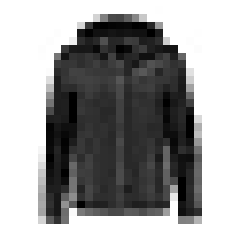

In [13]:
plt.imshow(X_train[0], cmap="binary")
plt.axis('off')
plt.show()

The labels are the class IDs (represented as uint8), from 0 to 9:

In [31]:
y_train

array([4, 0, 7, ..., 3, 0, 5], dtype=uint8)

Here are the corresponding class names:

In [32]:
class_names = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
               "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

So the first image in the training set is a coat:

In [33]:
class_names[y_train[0]]

'Coat'

The validation set contains 5,000 images, and the test set contains 10,000 images:

In [34]:
X_valid.shape

(5000, 28, 28)

In [35]:
X_test.shape

(10000, 28, 28)

Let's take a look at a sample of the images in the dataset:

Saving figure fashion_mnist_plot


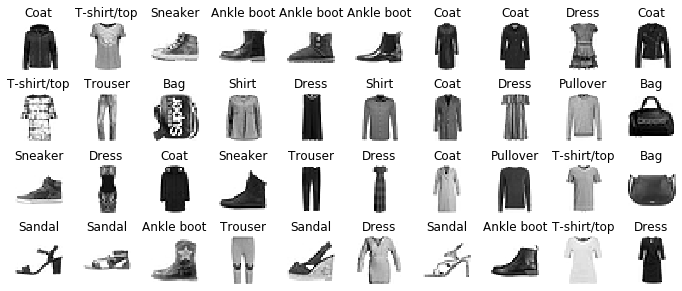

In [36]:
n_rows = 4
n_cols = 10
plt.figure(figsize=(n_cols * 1.2, n_rows * 1.2))
for row in range(n_rows):
    for col in range(n_cols):
        index = n_cols * row + col
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(X_train[index], cmap="binary", interpolation="nearest")
        plt.axis('off')
        plt.title(class_names[y_train[index]], fontsize=12)
plt.subplots_adjust(wspace=0.2, hspace=0.5)
save_fig('fashion_mnist_plot', tight_layout=False)
plt.show()

## Creating the model

In [15]:
model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[28, 28]))
model.add(keras.layers.Dense(300, activation="relu"))
model.add(keras.layers.Dense(100, activation="relu"))
model.add(keras.layers.Dense(10, activation="softmax"))

In [16]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [17]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="relu"),
    keras.layers.Dense(100, activation="relu"),
    keras.layers.Dense(10, activation="softmax")
])

In [18]:
model.layers

In [19]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 300)               235500    
_________________________________________________________________
dense_1 (Dense)              (None, 100)               30100     
_________________________________________________________________
dense_2 (Dense)              (None, 10)                1010      
Total params: 266,610
Trainable params: 266,610
Non-trainable params: 0
_________________________________________________________________


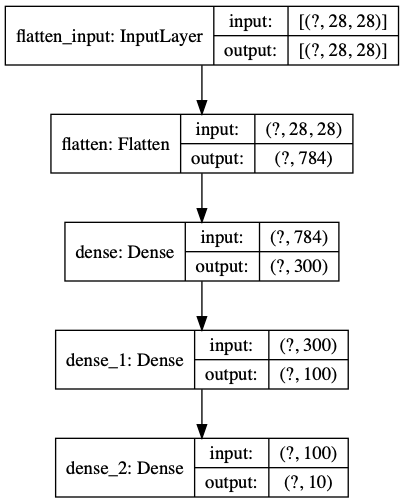

In [20]:
keras.utils.plot_model(model, "my_fashion_mnist_model.png", show_shapes=True)

In [21]:
hidden1 = model.layers[1]
hidden1.name

'dense'

In [22]:
model.get_layer(hidden1.name) is hidden1

True

In [45]:
weights, biases = hidden1.get_weights()

In [46]:
weights

array([[ 0.02448617, -0.00877795, -0.02189048, ..., -0.02766046,
         0.03859074, -0.06889391],
       [ 0.00476504, -0.03105379, -0.0586676 , ...,  0.00602964,
        -0.02763776, -0.04165364],
       [-0.06189284, -0.06901957,  0.07102345, ..., -0.04238207,
         0.07121518, -0.07331658],
       ...,
       [-0.03048757,  0.02155137, -0.05400612, ..., -0.00113463,
         0.00228987,  0.05581069],
       [ 0.07061854, -0.06960931,  0.07038955, ..., -0.00384101,
         0.00034875,  0.02878492],
       [-0.06022581,  0.01577859, -0.02585464, ..., -0.00527829,
         0.00272203, -0.06793761]], dtype=float32)

In [47]:
weights.shape

(784, 300)

In [34]:
biases

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.

In [48]:
biases.shape

(300,)

## Compiling the model

In [23]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(lr=0.01),
              metrics=["accuracy"])

This is equivalent to:

```python
model.compile(loss=keras.losses.sparse_categorical_crossentropy,
              optimizer=keras.optimizers.SGD(),
              metrics=[keras.metrics.sparse_categorical_accuracy])
```

## Training and evaluating the model

In [24]:
history = model.fit(X_train, y_train, epochs=30,
                    validation_data=(X_valid, y_valid))

Train on 55000 samples, validate on 5000 samples
Epoch 1/30
55000/55000 [==============================] - 4s 72us/sample - loss: 0.7226 - accuracy: 0.7641 - val_loss: 0.5073 - val_accuracy: 0.8320
Epoch 2/30
55000/55000 [==============================] - 4s 68us/sample - loss: 0.4844 - accuracy: 0.8321 - val_loss: 0.4540 - val_accuracy: 0.8488
Epoch 3/30
55000/55000 [==============================] - 4s 64us/sample - loss: 0.4414 - accuracy: 0.8465 - val_loss: 0.4378 - val_accuracy: 0.8498
Epoch 4/30
55000/55000 [==============================] - 4s 67us/sample - loss: 0.4129 - accuracy: 0.8547 - val_loss: 0.4158 - val_accuracy: 0.8558
Epoch 5/30
55000/55000 [==============================] - 4s 74us/sample - loss: 0.3927 - accuracy: 0.8617 - val_loss: 0.3810 - val_accuracy: 0.8646
Epoch 6/30
55000/55000 [==============================] - 4s 76us/sample - loss: 0.3770 - accuracy: 0.8666 - val_loss: 0.3729 - val_accuracy: 0.8686
Epoch 7/30
55000/55000 [==============================] -

In [25]:
history.params

{'batch_size': 32,
 'epochs': 30,
 'steps': 1719,
 'samples': 55000,
 'verbose': 0,
 'do_validation': True,
 'metrics': ['loss', 'accuracy', 'val_loss', 'val_accuracy']}

In [26]:
print(history.epoch)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]


In [27]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

Saving figure keras_learning_curves_plot


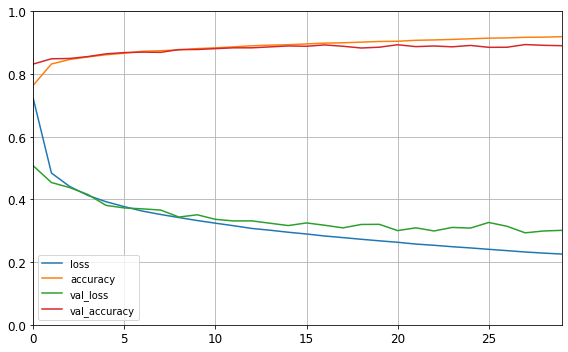

In [28]:
import pandas as pd

pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
save_fig("keras_learning_curves_plot")
plt.show()

In [54]:
model.evaluate(X_test, y_test)

10000/10000 [==============================] - 0s 44us/sample - loss: 0.3340 - accuracy: 0.8804


[0.333983403301239, 0.8804]

## Making Predictions

In [55]:
X_new = X_test[:3]
y_proba = model.predict(X_new)
y_proba.round(2)

array([[0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.01, 0.  , 0.98],
       [0.  , 0.  , 0.99, 0.  , 0.01, 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 1.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ]],
      dtype=float32)

In [57]:
y_pred = model.predict_classes(X_new)
y_pred

array([9, 2, 1])

In [58]:
np.array(class_names)[y_pred]

array(['Ankle boot', 'Pullover', 'Trouser'], dtype='<U11')

In [59]:
y_new = y_test[:3]
y_new

array([9, 2, 1], dtype=uint8)

Saving figure fashion_mnist_images_plot


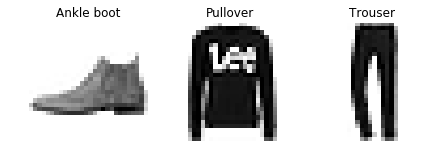

In [47]:
plt.figure(figsize=(7.2, 2.4))
for index, image in enumerate(X_new):
    plt.subplot(1, 3, index + 1)
    plt.imshow(image, cmap="binary", interpolation="nearest")
    plt.axis('off')
    plt.title(class_names[y_test[index]], fontsize=12)
plt.subplots_adjust(wspace=0.2, hspace=0.5)
save_fig('fashion_mnist_images_plot', tight_layout=False)
plt.show()

# Regression MLP

Let's load, split and scale the California housing dataset

In [12]:
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

housing = fetch_california_housing()

X_train_full, X_test, y_train_full, y_test = train_test_split(housing.data, housing.target, random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(X_train_full, y_train_full, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_valid = scaler.transform(X_valid)
X_test = scaler.transform(X_test)

In [13]:
np.random.seed(42)
tf.random.set_seed(42)
X_train.shape[1:]

(8,)

In [14]:
model = keras.models.Sequential([
    keras.layers.Dense(30, activation="relu", input_shape=X_train.shape[1:]),
    keras.layers.Dense(1)
])
model.compile(loss="mean_squared_error", optimizer=keras.optimizers.SGD(lr=1e-3))
history = model.fit(X_train, y_train, epochs=20, validation_data=(X_valid, y_valid))
mse_test = model.evaluate(X_test, y_test)
X_new = X_test[:3]
y_pred = model.predict(X_new)

Train on 11610 samples, validate on 3870 samples
Epoch 1/20
11610/11610 [==============================] - 1s 69us/sample - loss: 1.6205 - val_loss: 2.0374
Epoch 2/20
11610/11610 [==============================] - 1s 48us/sample - loss: 0.7162 - val_loss: 0.6571
Epoch 3/20
11610/11610 [==============================] - 1s 56us/sample - loss: 0.6356 - val_loss: 0.5996
Epoch 4/20
11610/11610 [==============================] - 1s 50us/sample - loss: 0.5989 - val_loss: 0.5662
Epoch 5/20
11610/11610 [==============================] - 1s 55us/sample - loss: 0.5713 - val_loss: 0.5489
Epoch 6/20
11610/11610 [==============================] - 1s 62us/sample - loss: 0.5491 - val_loss: 0.5204
Epoch 7/20
11610/11610 [==============================] - 1s 66us/sample - loss: 0.5301 - val_loss: 0.5018
Epoch 8/20
11610/11610 [==============================] - 1s 65us/sample - loss: 0.5142 - val_loss: 0.4815
Epoch 9/20
11610/11610 [==============================] - 1s 51us/sample - loss: 0.5004 - val_l

In [15]:
plt.plot(pd.DataFrame(history.history))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

NameError: name 'pd' is not defined

In [ ]:
y_pred

# Saving and Restoring

In [20]:
np.random.seed(42)
tf.random.set_seed(42)

In [21]:
model = keras.models.Sequential([
    keras.layers.Dense(30, activation="relu", input_shape=[8]),
    keras.layers.Dense(30, activation="relu"),
    keras.layers.Dense(1)
])    

In [22]:
model.compile(loss="mse", optimizer=keras.optimizers.SGD(lr=1e-3))
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_valid, y_valid))
mse_test = model.evaluate(X_test, y_test)

Train on 11610 samples, validate on 3870 samples
Epoch 1/10
11610/11610 [==============================] - 1s 73us/sample - loss: 1.8423 - val_loss: 5.2165
Epoch 2/10
11610/11610 [==============================] - 1s 54us/sample - loss: 0.6876 - val_loss: 0.7732
Epoch 3/10
11610/11610 [==============================] - 1s 52us/sample - loss: 0.5954 - val_loss: 0.5446
Epoch 4/10
11610/11610 [==============================] - 1s 70us/sample - loss: 0.5553 - val_loss: 0.5425
Epoch 5/10
11610/11610 [==============================] - 1s 60us/sample - loss: 0.5268 - val_loss: 0.5539
Epoch 6/10
11610/11610 [==============================] - 1s 56us/sample - loss: 0.5049 - val_loss: 0.4701
Epoch 7/10
11610/11610 [==============================] - 1s 85us/sample - loss: 0.4852 - val_loss: 0.4562
Epoch 8/10
11610/11610 [==============================] - 1s 51us/sample - loss: 0.4706 - val_loss: 0.4452
Epoch 9/10
11610/11610 [==============================] - 1s 53us/sample - loss: 0.4576 - val_l

In [23]:
model.save("my_keras_model.h5")

In [24]:
model = keras.models.load_model("my_keras_model.h5")

In [25]:
model.predict(X_new)

array([[0.551559 ],
       [1.6555369],
       [3.0014234]], dtype=float32)

In [26]:
model.save_weights("my_keras_weights.ckpt")

In [27]:
model.load_weights("my_keras_weights.ckpt")

# Using Callbacks during Training

In [28]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [29]:
model = keras.models.Sequential([
    keras.layers.Dense(30, activation="relu", input_shape=[8]),
    keras.layers.Dense(30, activation="relu"),
    keras.layers.Dense(1)
])    

In [30]:
model.compile(loss="mse", optimizer=keras.optimizers.SGD(lr=1e-3))
checkpoint_cb = keras.callbacks.ModelCheckpoint("my_keras_model.h5", save_best_only=True)
history = model.fit(X_train, y_train, epochs=10,
                    validation_data=(X_valid, y_valid),
                    callbacks=[checkpoint_cb])
model = keras.models.load_model("my_keras_model.h5") # rollback to best model
mse_test = model.evaluate(X_test, y_test)

Train on 11610 samples, validate on 3870 samples
Epoch 1/10
11610/11610 [==============================] - 1s 89us/sample - loss: 1.8423 - val_loss: 5.2165
Epoch 2/10
11610/11610 [==============================] - 1s 78us/sample - loss: 0.6876 - val_loss: 0.7732
Epoch 3/10
11610/11610 [==============================] - 1s 64us/sample - loss: 0.5954 - val_loss: 0.5446
Epoch 4/10
11610/11610 [==============================] - 1s 62us/sample - loss: 0.5553 - val_loss: 0.5425
Epoch 5/10
11610/11610 [==============================] - 1s 60us/sample - loss: 0.5268 - val_loss: 0.5539
Epoch 6/10
11610/11610 [==============================] - 1s 60us/sample - loss: 0.5049 - val_loss: 0.4701
Epoch 7/10
11610/11610 [==============================] - 1s 59us/sample - loss: 0.4852 - val_loss: 0.4562
Epoch 8/10
11610/11610 [==============================] - 1s 69us/sample - loss: 0.4706 - val_loss: 0.4452
Epoch 9/10
11610/11610 [==============================] - 1s 82us/sample - loss: 0.4576 - val_l

In [31]:
model.compile(loss="mse", optimizer=keras.optimizers.SGD(lr=1e-3))
early_stopping_cb = keras.callbacks.EarlyStopping(patience=10,
                                                  restore_best_weights=True)
history = model.fit(X_train, y_train, epochs=100,
                    validation_data=(X_valid, y_valid),
                    callbacks=[checkpoint_cb, early_stopping_cb])
mse_test = model.evaluate(X_test, y_test)

Train on 11610 samples, validate on 3870 samples
Epoch 1/100
11610/11610 [==============================] - 1s 70us/sample - loss: 0.4385 - val_loss: 0.4287
Epoch 2/100
11610/11610 [==============================] - 1s 51us/sample - loss: 0.4319 - val_loss: 0.4117
Epoch 3/100
11610/11610 [==============================] - 1s 54us/sample - loss: 0.4252 - val_loss: 0.3975
Epoch 4/100
11610/11610 [==============================] - 1s 51us/sample - loss: 0.4199 - val_loss: 0.3943
Epoch 5/100
11610/11610 [==============================] - 1s 56us/sample - loss: 0.4150 - val_loss: 0.3964
Epoch 6/100
11610/11610 [==============================] - 1s 78us/sample - loss: 0.4110 - val_loss: 0.3907
Epoch 7/100
11610/11610 [==============================] - 1s 79us/sample - loss: 0.4070 - val_loss: 0.3823
Epoch 8/100
11610/11610 [==============================] - 1s 77us/sample - loss: 0.4036 - val_loss: 0.3786
Epoch 9/100
11610/11610 [==============================] - 1s 61us/sample - loss: 0.400

Epoch 76/100
11610/11610 [==============================] - 1s 61us/sample - loss: 0.3341 - val_loss: 0.3196
Epoch 77/100
11610/11610 [==============================] - 1s 62us/sample - loss: 0.3338 - val_loss: 0.3608
Epoch 78/100
11610/11610 [==============================] - 1s 76us/sample - loss: 0.3336 - val_loss: 0.3295
Epoch 79/100
11610/11610 [==============================] - 1s 83us/sample - loss: 0.3331 - val_loss: 0.3927
Epoch 80/100
11610/11610 [==============================] - 1s 69us/sample - loss: 0.3332 - val_loss: 0.3167
Epoch 81/100
11610/11610 [==============================] - 1s 87us/sample - loss: 0.3317 - val_loss: 0.3783
Epoch 82/100
11610/11610 [==============================] - 1s 62us/sample - loss: 0.3322 - val_loss: 0.3154
Epoch 83/100
11610/11610 [==============================] - 1s 56us/sample - loss: 0.3315 - val_loss: 0.3538
Epoch 84/100
11610/11610 [==============================] - 1s 56us/sample - loss: 0.3312 - val_loss: 0.3282
Epoch 85/100
11610/

# TensorBoard

In [32]:
root_logdir = os.path.join(os.curdir, "my_logs")

In [33]:
def get_run_logdir():
    import time
    run_id = time.strftime("run_%Y_%m_%d-%H_%M_%S")
    return os.path.join(root_logdir, run_id)

run_logdir = get_run_logdir()
run_logdir

'./my_logs/run_2020_10_20-13_19_36'

In [34]:
model = keras.models.Sequential([
    keras.layers.Dense(30, activation="relu", input_shape=[8]),
    keras.layers.Dense(30, activation="relu"),
    keras.layers.Dense(1)
])    
model.compile(loss="mse", optimizer=keras.optimizers.SGD(lr=1e-3))

In [35]:
tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)
history = model.fit(X_train, y_train, epochs=30,
                    validation_data=(X_valid, y_valid),
                    callbacks=[checkpoint_cb, tensorboard_cb])

Train on 11610 samples, validate on 3870 samples
Epoch 1/30
11610/11610 [==============================] - 1s 123us/sample - loss: 1.4548 - val_loss: 0.8192
Epoch 2/30
11610/11610 [==============================] - 1s 98us/sample - loss: 0.7412 - val_loss: 0.6668
Epoch 3/30
11610/11610 [==============================] - 1s 98us/sample - loss: 0.6521 - val_loss: 0.6015
Epoch 4/30
11610/11610 [==============================] - 1s 82us/sample - loss: 0.5952 - val_loss: 0.5492
Epoch 5/30
11610/11610 [==============================] - 1s 82us/sample - loss: 0.5530 - val_loss: 0.5147
Epoch 6/30
11610/11610 [==============================] - 1s 83us/sample - loss: 0.5200 - val_loss: 0.4739
Epoch 7/30
11610/11610 [==============================] - 1s 73us/sample - loss: 0.4933 - val_loss: 0.4511
Epoch 8/30
11610/11610 [==============================] - 1s 93us/sample - loss: 0.4724 - val_loss: 0.4351
Epoch 9/30
11610/11610 [==============================] - 1s 71us/sample - loss: 0.4558 - val_

To start the TensorBoard server, one option is to open a terminal, if needed activate the virtualenv where you installed TensorBoard, go to this notebook's directory, then type:

```bash
$ tensorboard --logdir=./my_logs --port=6006
```

You can then open your web browser to [localhost:6006](http://localhost:6006) and use TensorBoard. Once you are done, press Ctrl-C in the terminal window, this will shutdown the TensorBoard server.

Alternatively, you can load TensorBoard's Jupyter extension and run it like this:

In [36]:
%load_ext tensorboard
%tensorboard --logdir=./my_logs --port=6006

Reusing TensorBoard on port 6006 (pid 96088), started 3:10:44 ago. (Use '!kill 96088' to kill it.)

In [37]:
run_logdir2 = get_run_logdir()
run_logdir2

'./my_logs/run_2020_10_20-13_21_44'

In [38]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [39]:
model = keras.models.Sequential([
    keras.layers.Dense(30, activation="relu", input_shape=[8]),
    keras.layers.Dense(30, activation="relu"),
    keras.layers.Dense(1)
])    
model.compile(loss="mse", optimizer=keras.optimizers.SGD(lr=0.05))

In [40]:
tensorboard_cb = keras.callbacks.TensorBoard(run_logdir2)
history = model.fit(X_train, y_train, epochs=30,
                    validation_data=(X_valid, y_valid),
                    callbacks=[checkpoint_cb, tensorboard_cb])

Train on 11610 samples, validate on 3870 samples
Epoch 1/30
11610/11610 [==============================] - 1s 92us/sample - loss: 5.6341 - val_loss: 1.3205
Epoch 2/30
11610/11610 [==============================] - 1s 70us/sample - loss: 1.2704 - val_loss: 1.0757
Epoch 3/30
11610/11610 [==============================] - 1s 85us/sample - loss: 0.9370 - val_loss: 0.7769
Epoch 4/30
11610/11610 [==============================] - 1s 84us/sample - loss: 0.8854 - val_loss: 0.8254
Epoch 5/30
11610/11610 [==============================] - 1s 76us/sample - loss: 0.9501 - val_loss: 0.9415
Epoch 6/30
11610/11610 [==============================] - 1s 89us/sample - loss: 0.8283 - val_loss: 0.6111
Epoch 7/30
11610/11610 [==============================] - 1s 101us/sample - loss: 0.8095 - val_loss: 0.7394
Epoch 8/30
11610/11610 [==============================] - 1s 91us/sample - loss: 1.1857 - val_loss: 1.0356
Epoch 9/30
11610/11610 [==============================] - 1s 72us/sample - loss: 0.8920 - val_

Notice how TensorBoard now sees two runs, and you can compare the learning curves.

Check out the other available logging options:

In [92]:
help(keras.callbacks.TensorBoard.__init__)

Help on function __init__ in module tensorflow.python.keras.callbacks:

__init__(self, log_dir='logs', histogram_freq=0, write_graph=True, write_images=False, update_freq='epoch', profile_batch=2, embeddings_freq=0, embeddings_metadata=None, **kwargs)
    Initialize self.  See help(type(self)) for accurate signature.



# Hyperparameter Tuning

In [64]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [65]:
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

housing = fetch_california_housing()

X_train_full, X_test, y_train_full, y_test = train_test_split(housing.data, housing.target, random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(X_train_full, y_train_full, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_valid = scaler.transform(X_valid)
X_test = scaler.transform(X_test)

In [67]:
def build_model(n_hidden=1, n_neurons=30, learning_rate=3e-3, input_shape=[8]):
    model = keras.models.Sequential()
    model.add(keras.layers.InputLayer(input_shape=input_shape))
    for layer in range(n_hidden):
        model.add(keras.layers.Dense(n_neurons, activation="relu"))
    model.add(keras.layers.Dense(1))
    optimizer = keras.optimizers.SGD(lr=learning_rate)
    model.compile(loss="mse", optimizer=optimizer)
    return model

In [68]:
keras_reg = keras.wrappers.scikit_learn.KerasRegressor(build_model)

In [69]:
keras_reg.fit(X_train, y_train, epochs=100,
              validation_data=(X_valid, y_valid),
              callbacks=[keras.callbacks.EarlyStopping(patience=10)])

Train on 11610 samples, validate on 3870 samples
Epoch 1/100
11610/11610 [==============================] - 1s 63us/sample - loss: 1.1399 - val_loss: 24.4309
Epoch 2/100
11610/11610 [==============================] - 0s 38us/sample - loss: 0.7393 - val_loss: 3.2896
Epoch 3/100
11610/11610 [==============================] - 1s 51us/sample - loss: 0.5374 - val_loss: 0.6080
Epoch 4/100
11610/11610 [==============================] - 0s 37us/sample - loss: 0.4796 - val_loss: 0.4532
Epoch 5/100
11610/11610 [==============================] - 1s 43us/sample - loss: 0.4536 - val_loss: 0.4221
Epoch 6/100
11610/11610 [==============================] - 0s 38us/sample - loss: 0.4373 - val_loss: 0.4144
Epoch 7/100
11610/11610 [==============================] - 0s 39us/sample - loss: 0.4256 - val_loss: 0.4025
Epoch 8/100
11610/11610 [==============================] - 0s 40us/sample - loss: 0.4178 - val_loss: 0.3938
Epoch 9/100
11610/11610 [==============================] - 0s 39us/sample - loss: 0.41

In [70]:
mse_test = keras_reg.score(X_test, y_test)

5160/5160 [==============================] - 0s 29us/sample - loss: 0.3464


In [73]:
X_new = X_test[:3]
y_pred = keras_reg.predict(X_new)

In [74]:
np.random.seed(42)
tf.random.set_seed(42)

**Warning**: the following cell crashes at the end of training. This seems to be caused by [Keras issue #13586](https://github.com/keras-team/keras/issues/13586), which was triggered by a recent change in Scikit-Learn. [Pull Request #13598](https://github.com/keras-team/keras/pull/13598) seems to fix the issue, so this problem should be resolved soon.

In [75]:
from scipy.stats import reciprocal
from sklearn.model_selection import RandomizedSearchCV

param_distribs = {
    "n_hidden": [0, 1, 2, 3],
    "n_neurons": np.arange(1, 100),
    "learning_rate": reciprocal(3e-4, 3e-2),
}

rnd_search_cv = RandomizedSearchCV(keras_reg, param_distribs, n_iter=10, cv=3, verbose=2)
rnd_search_cv.fit(X_train, y_train, epochs=100,
                  validation_data=(X_valid, y_valid),
                  callbacks=[keras.callbacks.EarlyStopping(patience=10)])

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV] learning_rate=0.001683454924600351, n_hidden=0, n_neurons=15 ....
Train on 7740 samples, validate on 3870 samples
Epoch 1/100


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


7740/7740 [==============================] - 1s 76us/sample - loss: 3.5574 - val_loss: 1.8536
Epoch 2/100
7740/7740 [==============================] - 0s 45us/sample - loss: 1.3316 - val_loss: 0.9380
Epoch 3/100
7740/7740 [==============================] - 0s 49us/sample - loss: 0.8573 - val_loss: 0.8545
Epoch 4/100
7740/7740 [==============================] - 0s 47us/sample - loss: 0.7344 - val_loss: 0.9545
Epoch 5/100
7740/7740 [==============================] - 0s 41us/sample - loss: 0.6943 - val_loss: 0.7248
Epoch 6/100
7740/7740 [==============================] - 0s 54us/sample - loss: 0.6682 - val_loss: 0.7356
Epoch 7/100
7740/7740 [==============================] - 0s 40us/sample - loss: 0.6494 - val_loss: 0.9732
Epoch 8/100
7740/7740 [==============================] - 0s 50us/sample - loss: 0.6408 - val_loss: 0.6175
Epoch 9/100
7740/7740 [==============================] - 0s 40us/sample - loss: 0.6256 - val_loss: 0.5877
Epoch 10/100
7740/7740 [==============================] - 

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   12.0s remaining:    0.0s


7740/7740 [==============================] - 0s 64us/sample - loss: 3.5541 - val_loss: 23.2063
Epoch 2/100
7740/7740 [==============================] - 0s 41us/sample - loss: 1.4756 - val_loss: 10.9096
Epoch 3/100
7740/7740 [==============================] - 0s 40us/sample - loss: 1.0159 - val_loss: 4.5194
Epoch 4/100
7740/7740 [==============================] - 0s 41us/sample - loss: 0.8738 - val_loss: 1.5793
Epoch 5/100
7740/7740 [==============================] - 0s 40us/sample - loss: 0.8034 - val_loss: 0.7218
Epoch 6/100
7740/7740 [==============================] - 0s 40us/sample - loss: 0.7549 - val_loss: 1.1511
Epoch 7/100
7740/7740 [==============================] - 0s 41us/sample - loss: 0.7166 - val_loss: 2.3325
Epoch 8/100
7740/7740 [==============================] - 0s 43us/sample - loss: 0.6854 - val_loss: 3.9493
Epoch 9/100
7740/7740 [==============================] - 0s 41us/sample - loss: 0.6593 - val_loss: 5.7393
Epoch 10/100
7740/7740 [==============================] 

7740/7740 [==============================] - 0s 49us/sample - loss: 0.3700 - val_loss: 0.3698
Epoch 56/100
7740/7740 [==============================] - 0s 48us/sample - loss: 0.3691 - val_loss: 0.3854
Epoch 57/100
7740/7740 [==============================] - 0s 46us/sample - loss: 0.3682 - val_loss: 0.3874
Epoch 58/100
7740/7740 [==============================] - 0s 46us/sample - loss: 0.3670 - val_loss: 0.3942
Epoch 59/100
7740/7740 [==============================] - 0s 45us/sample - loss: 0.3663 - val_loss: 0.3821
Epoch 60/100
7740/7740 [==============================] - 0s 46us/sample - loss: 0.3654 - val_loss: 0.3882
Epoch 61/100
7740/7740 [==============================] - 0s 46us/sample - loss: 0.3644 - val_loss: 0.3779
Epoch 62/100
7740/7740 [==============================] - 0s 46us/sample - loss: 0.3634 - val_loss: 0.3693
Epoch 63/100
7740/7740 [==============================] - 0s 46us/sample - loss: 0.3628 - val_loss: 0.3734
Epoch 64/100
7740/7740 [==========================

7740/7740 [==============================] - 1s 69us/sample - loss: 0.8942 - val_loss: 4.2789
Epoch 4/100
7740/7740 [==============================] - 0s 54us/sample - loss: 0.8105 - val_loss: 3.3544
Epoch 5/100
7740/7740 [==============================] - 0s 46us/sample - loss: 0.7686 - val_loss: 2.6742
Epoch 6/100
7740/7740 [==============================] - 0s 46us/sample - loss: 0.7406 - val_loss: 2.2971
Epoch 7/100
7740/7740 [==============================] - 0s 46us/sample - loss: 0.7187 - val_loss: 2.0216
Epoch 8/100
7740/7740 [==============================] - 0s 51us/sample - loss: 0.7000 - val_loss: 1.7849
Epoch 9/100
7740/7740 [==============================] - 0s 44us/sample - loss: 0.6825 - val_loss: 1.5810
Epoch 10/100
7740/7740 [==============================] - 0s 50us/sample - loss: 0.6676 - val_loss: 1.4502
Epoch 11/100
7740/7740 [==============================] - 0s 48us/sample - loss: 0.6530 - val_loss: 1.3239
Epoch 12/100
7740/7740 [==============================] 

Epoch 5/100
7740/7740 [==============================] - 0s 44us/sample - loss: 1.1658 - val_loss: 20.2997
Epoch 6/100
7740/7740 [==============================] - 0s 52us/sample - loss: 1.0236 - val_loss: 14.4998
Epoch 7/100
7740/7740 [==============================] - 0s 50us/sample - loss: 0.9247 - val_loss: 10.3206
Epoch 8/100
7740/7740 [==============================] - 0s 47us/sample - loss: 0.8582 - val_loss: 7.2174
Epoch 9/100
7740/7740 [==============================] - 0s 47us/sample - loss: 0.8127 - val_loss: 5.0609
Epoch 10/100
7740/7740 [==============================] - 0s 43us/sample - loss: 0.7805 - val_loss: 3.8504
Epoch 11/100
7740/7740 [==============================] - 0s 43us/sample - loss: 0.7553 - val_loss: 2.6823
Epoch 12/100
7740/7740 [==============================] - 0s 50us/sample - loss: 0.7345 - val_loss: 1.9608
Epoch 13/100
7740/7740 [==============================] - 0s 55us/sample - loss: 0.7165 - val_loss: 1.5395
Epoch 14/100
7740/7740 [===============

7740/7740 [==============================] - 0s 51us/sample - loss: 0.4334 - val_loss: 0.4516
Epoch 50/100
7740/7740 [==============================] - 0s 46us/sample - loss: 0.4319 - val_loss: 0.4455
Epoch 51/100
7740/7740 [==============================] - 0s 47us/sample - loss: 0.4304 - val_loss: 0.4405
Epoch 52/100
7740/7740 [==============================] - 0s 59us/sample - loss: 0.4292 - val_loss: 0.4437
Epoch 53/100
7740/7740 [==============================] - 0s 56us/sample - loss: 0.4277 - val_loss: 0.4417
Epoch 54/100
7740/7740 [==============================] - 0s 56us/sample - loss: 0.4266 - val_loss: 0.4433
Epoch 55/100
7740/7740 [==============================] - 0s 47us/sample - loss: 0.4252 - val_loss: 0.4468
Epoch 56/100
7740/7740 [==============================] - 0s 47us/sample - loss: 0.4241 - val_loss: 0.4536
Epoch 57/100
7740/7740 [==============================] - 0s 49us/sample - loss: 0.4228 - val_loss: 0.4470
Epoch 58/100
7740/7740 [==========================

Epoch 20/100
7740/7740 [==============================] - 0s 52us/sample - loss: 0.3429 - val_loss: 0.3633
Epoch 21/100
7740/7740 [==============================] - 0s 58us/sample - loss: 0.3408 - val_loss: 0.3366
Epoch 22/100
7740/7740 [==============================] - 0s 55us/sample - loss: 0.3400 - val_loss: 0.3583
Epoch 23/100
7740/7740 [==============================] - 0s 50us/sample - loss: 0.3397 - val_loss: 0.3759
Epoch 24/100
7740/7740 [==============================] - 0s 51us/sample - loss: 0.3373 - val_loss: 0.3592
Epoch 25/100
7740/7740 [==============================] - 0s 64us/sample - loss: 0.3364 - val_loss: 0.3754
Epoch 26/100
7740/7740 [==============================] - 0s 48us/sample - loss: 0.3354 - val_loss: 0.3558
Epoch 27/100
7740/7740 [==============================] - 0s 52us/sample - loss: 0.3343 - val_loss: 0.3720
Epoch 28/100
7740/7740 [==============================] - 0s 44us/sample - loss: 0.3324 - val_loss: 0.3559
Epoch 29/100
7740/7740 [=============

7740/7740 [==============================] - 0s 47us/sample - loss: 0.4282 - val_loss: 0.4172
Epoch 71/100
7740/7740 [==============================] - 0s 47us/sample - loss: 0.4260 - val_loss: 0.4151
Epoch 72/100
7740/7740 [==============================] - 0s 46us/sample - loss: 0.4243 - val_loss: 0.4132
Epoch 73/100
7740/7740 [==============================] - 0s 46us/sample - loss: 0.4224 - val_loss: 0.4112
Epoch 74/100
7740/7740 [==============================] - 0s 47us/sample - loss: 0.4204 - val_loss: 0.4092
Epoch 75/100
7740/7740 [==============================] - 0s 46us/sample - loss: 0.4188 - val_loss: 0.4074
Epoch 76/100
7740/7740 [==============================] - 0s 46us/sample - loss: 0.4170 - val_loss: 0.4056
Epoch 77/100
7740/7740 [==============================] - 0s 46us/sample - loss: 0.4152 - val_loss: 0.4039
Epoch 78/100
7740/7740 [==============================] - 0s 46us/sample - loss: 0.4135 - val_loss: 0.4026
Epoch 79/100
7740/7740 [==========================

7740/7740 [==============================] - 0s 37us/sample - loss: 0.3988 - val_loss: 0.4753
Epoch 14/100
7740/7740 [==============================] - 0s 38us/sample - loss: 0.3943 - val_loss: 0.5508
Epoch 15/100
7740/7740 [==============================] - 0s 37us/sample - loss: 0.3902 - val_loss: 0.5443
Epoch 16/100
7740/7740 [==============================] - 0s 37us/sample - loss: 0.3896 - val_loss: 0.6561
Epoch 17/100
7740/7740 [==============================] - 0s 37us/sample - loss: 0.3867 - val_loss: 0.6874
Epoch 18/100
7740/7740 [==============================] - 0s 38us/sample - loss: 0.3837 - val_loss: 0.7188
Epoch 19/100
3870/3870 [==============================] - 0s 19us/sample - loss: 0.3968
[CV]  learning_rate=0.005153286333701512, n_hidden=1, n_neurons=22, total=   5.9s
[CV] learning_rate=0.005153286333701512, n_hidden=1, n_neurons=22 ....
Train on 7740 samples, validate on 3870 samples
Epoch 1/100
7740/7740 [==============================] - 0s 61us/sample - loss: 1.

7740/7740 [==============================] - 0s 44us/sample - loss: 1.0921 - val_loss: 20.0378
Epoch 11/100
7740/7740 [==============================] - 0s 37us/sample - loss: 0.9744 - val_loss: 19.9971
Epoch 12/100
7740/7740 [==============================] - 0s 36us/sample - loss: 0.8855 - val_loss: 19.9839
Epoch 13/100
7740/7740 [==============================] - 0s 37us/sample - loss: 0.8178 - val_loss: 19.9964
Epoch 14/100
7740/7740 [==============================] - 0s 47us/sample - loss: 0.7659 - val_loss: 20.0215
Epoch 15/100
7740/7740 [==============================] - 0s 42us/sample - loss: 0.7260 - val_loss: 20.0579
Epoch 16/100
7740/7740 [==============================] - 0s 38us/sample - loss: 0.6950 - val_loss: 20.1105
Epoch 17/100
7740/7740 [==============================] - 0s 44us/sample - loss: 0.6709 - val_loss: 20.1648
Epoch 18/100
7740/7740 [==============================] - 0s 37us/sample - loss: 0.6518 - val_loss: 20.2247
Epoch 19/100
7740/7740 [=================

7740/7740 [==============================] - 0s 41us/sample - loss: 0.3354 - val_loss: 0.3228
Epoch 45/100
7740/7740 [==============================] - 0s 44us/sample - loss: 0.3324 - val_loss: 0.4816
Epoch 46/100
7740/7740 [==============================] - 0s 42us/sample - loss: 0.3331 - val_loss: 0.4228
Epoch 47/100
7740/7740 [==============================] - 0s 39us/sample - loss: 0.3331 - val_loss: 0.6872
Epoch 48/100
7740/7740 [==============================] - 0s 40us/sample - loss: 0.3319 - val_loss: 0.3177
Epoch 49/100
7740/7740 [==============================] - 0s 39us/sample - loss: 0.3295 - val_loss: 0.6891
Epoch 50/100
7740/7740 [==============================] - 0s 43us/sample - loss: 0.3376 - val_loss: 0.5869
Epoch 51/100
7740/7740 [==============================] - 0s 38us/sample - loss: 0.3310 - val_loss: 0.5921
Epoch 52/100
7740/7740 [==============================] - 0s 38us/sample - loss: 0.3296 - val_loss: 0.4285
Epoch 53/100
7740/7740 [==========================

[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:  6.8min finished


11610/11610 [==============================] - 1s 54us/sample - loss: 1.0377 - val_loss: 7.6220
Epoch 2/100
11610/11610 [==============================] - 0s 35us/sample - loss: 0.5969 - val_loss: 0.9913
Epoch 3/100
11610/11610 [==============================] - 0s 34us/sample - loss: 0.4811 - val_loss: 0.5397
Epoch 4/100
11610/11610 [==============================] - 0s 39us/sample - loss: 0.4390 - val_loss: 0.4682
Epoch 5/100
11610/11610 [==============================] - 0s 38us/sample - loss: 0.4160 - val_loss: 0.4983
Epoch 6/100
11610/11610 [==============================] - 0s 38us/sample - loss: 0.4016 - val_loss: 0.4798
Epoch 7/100
11610/11610 [==============================] - 0s 39us/sample - loss: 0.3904 - val_loss: 0.4129
Epoch 8/100
11610/11610 [==============================] - 0s 43us/sample - loss: 0.3833 - val_loss: 0.3919
Epoch 9/100
11610/11610 [==============================] - 0s 42us/sample - loss: 0.3763 - val_loss: 0.4254
Epoch 10/100
11610/11610 [==============

RandomizedSearchCV(cv=3, error_score='raise-deprecating',
                   estimator=<tensorflow.python.keras.wrappers.scikit_learn.KerasRegressor object at 0x106591550>,
                   iid='warn', n_iter=10, n_jobs=None,
                   param_distributions={'learning_rate': <scipy.stats._distn_infrastructure.rv_frozen object at 0x143c15d50>,
                                        'n_hidden': [0, 1, 2, 3],
                                        'n_neurons': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12,...
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51,
       52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68,
       69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85,
       86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99])},
                   pre_dispatch='2*n_jobs', random_state=None, refit=True,
                   return_tr

In [76]:
rnd_search_cv.best_params_

{'learning_rate': 0.0033625641252688094, 'n_hidden': 2, 'n_neurons': 42}

In [102]:
rnd_search_cv.best_score_

-0.35952892616378346

In [103]:
rnd_search_cv.best_estimator_

In [104]:
rnd_search_cv.score(X_test, y_test)

5160/5160 [==============================] - 0s 15us/sample - loss: 0.3065


-0.30652404945026074

In [105]:
model = rnd_search_cv.best_estimator_.model
model

In [106]:
model.evaluate(X_test, y_test)

5160/5160 [==============================] - 0s 15us/sample - loss: 0.3065


0.30652404945026074

# Exercise 

*Exercise: Train a deep MLP on the MNIST dataset (you can load it using `keras.datasets.mnist.load_data()`. See if you can get over 98% precision. Try adding all the bells and whistles—save checkpoints, use early stopping, and plot learning curves using TensorBoard.*

Steps to carry out:
- load the dataset 
- explore dataset and normalise it
- define the NN model
- compile the model
- evaluate the model
